In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

sstyle = "seaborn-poster"
plt.style.use(sstyle)
plt.rc('font',family = 'serif')

Data from the [Mexico City Atmospheric Monitoring System (SIMAT)](http://www.aire.cdmx.gob.mx/default.php?opc=%27aKBhnmI=%27&opcion=Zg==)

In [2]:
def get_data(year,zone):
    # Creating dictionary to retrieve units from id
    units = (
        pd.read_csv("data/info_parameters/cat_unidades.csv", 
                    encoding="latin-1")
        .rename(columns={"clave_unidad":"unit"})
        .drop(columns=["nombre_unidad"])
        .set_index("id_unidad")
    )["unit"].to_dict()
    # Reading data per year
    df = (
        pd.read_csv(f"data/contaminantes_{year}.csv",
                    skiprows=10).rename(columns={"unit":"id_unidad"})
    )
    df["units"] = df.id_unidad.map(units); df = df.drop(columns=["id_unidad"])
    # Uncomment the following line for data diagnostics:
    #print(f"Available zones for this dataset: {df.id_station.unique()}")
    df = df[df.id_station.isin([zone])]; df = df.drop(columns=["id_station"])
    # Getting datasets per contaminat
    contaminants = df.id_parameter.unique(); DF_c = []
    for c in contaminants:
        df_ = df[df.id_parameter.isin([c])]
        df_.date = (
            pd.to_datetime(
                df_.date.str.replace(" 24:00"," 00:00"),
                format="%d/%m/%Y %H:%M"
            )
        )
        df_.set_index("date",inplace=True)
        c_name_unit = ((df_.id_parameter.unique()[0], df_.units.unique()[0]))
        df_ = df_.groupby(pd.Grouper(freq='D')).mean()
        df_.rename(columns={"value":f"{c_name_unit[0]} [{c_name_unit[-1]}]"},inplace=True)
        DF_c.append(df_)  
    # Creating a datafram instead of a list of dataframes.
    DF_ = DF_c[0]
    for df_ in DF_c[1:]:
        DF_ = DF_.join(df_) 
    return DF_

Based on data diagnostics, I am going to work with the Miguel Hidalgo zone. It appears to be the most complete set of data for the contaminants: CO, NO, NO$_2$, NO$_x$, O$_3$, and SO$_2$, for the whole range of time: 2017 - 2022.

In [3]:
contaminants = [ 'CO [ppm]', 'NO [ppb]', 'NO2 [ppb]',
                'NOX [ppb]', 'O3 [ppb]', 'SO2 [ppb]']
# Joining pre-covid and post-covid data:
pre_covid = [
    get_data(2017,"MGH")[contaminants],
    get_data(2018,"MGH")[contaminants],
    get_data(2019,"MGH")[contaminants]
]; df_pre = pd.concat(pre_covid, axis=0)
pos_covid = [
    get_data(2020,"MGH")[contaminants],
    get_data(2021,"MGH")[contaminants],
    get_data(2022,"MGH")[contaminants]
]; df_pos = pd.concat(pos_covid, axis=0)

In [10]:
cc = 2

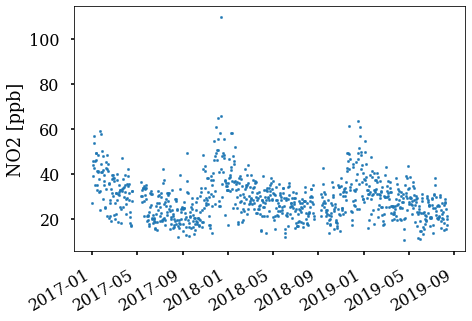

In [11]:
plt.figure(figsize=(7,5))
plt.scatter(df_pre.index, df_pre[contaminants[cc]], s=5)
plt.gcf().autofmt_xdate()
plt.ylabel(contaminants[cc]);

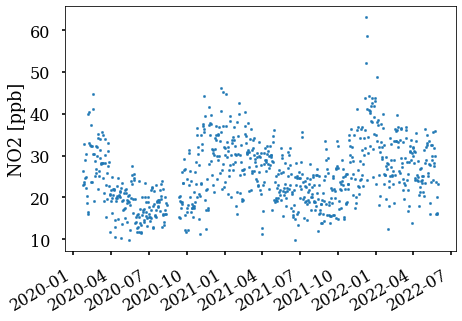

In [12]:
plt.figure(figsize=(7,5))
plt.scatter(df_pos.index, df_pos[contaminants[cc]], s=5)
plt.gcf().autofmt_xdate()
plt.ylabel(contaminants[cc]);